In [51]:
import sys
!{sys.executable} -m pip install ultralytics opencv-python matplotlib seaborn


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip


In [52]:
import ultralytics
import os
import shutil
import random
import yaml
import matplotlib.pyplot as plt
import cv2
from ultralytics import YOLO

ultralytics.checks()

Ultralytics 8.3.159 🚀 Python-3.13.3 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 4060, 7816MiB)
Setup complete ✅ (12 CPUs, 30.9 GB RAM, 102.2/227.8 GB disk)


In [53]:
# Import class names from existing YAML file
def load_class_names_from_yaml(yaml_path):
    """Load class names from existing data.yaml file."""
    if os.path.exists(yaml_path):
        with open(yaml_path, 'r') as f:
            data = yaml.safe_load(f)

        class_names = data.get('names', [])
        if isinstance(class_names, dict):
            # If names is a dictionary (class_id: class_name), convert to list
            class_names = [class_names[i] for i in sorted(class_names.keys())]
        elif isinstance(class_names, list):
            # If names is already a list, use as is
            pass
        else:
            raise ValueError("Class names in YAML should be either a list or dictionary")

        # Validate class names
        if not class_names:
            raise ValueError("No class names found in YAML file")

        # Check for valid class names (no empty strings)
        class_names = [str(name).strip() for name in class_names if str(name).strip()]

        print(f"Loaded {len(class_names)} class names from {yaml_path}")
        print(f"Classes: {class_names}")
        return class_names
    else:
        raise FileNotFoundError(f"YAML file not found: {yaml_path}")

def validate_yaml_structure(yaml_path):
    """Validate the structure of a YAML file for YOLOv8 compatibility."""
    try:
        with open(yaml_path, 'r') as f:
            data = yaml.safe_load(f)

        required_keys = ['names']
        optional_keys = ['path', 'train', 'val', 'test', 'nc']

        missing_keys = [key for key in required_keys if key not in data]
        if missing_keys:
            print(f"Warning: Missing required keys in YAML: {missing_keys}")

        present_keys = [key for key in optional_keys if key in data]
        print(f"Present optional keys: {present_keys}")

        # Validate nc matches number of names
        if 'nc' in data and 'names' in data:
            names = data['names']
            if isinstance(names, list):
                expected_nc = len(names)
            elif isinstance(names, dict):
                expected_nc = len(names)
            else:
                expected_nc = 0

            if data['nc'] != expected_nc:
                print(f"Warning: 'nc' ({data['nc']}) doesn't match number of class names ({expected_nc})")

        return True
    except Exception as e:
        print(f"Error validating YAML: {e}")
        return False

# Dataset configuration
DATASET_PATH = "data/YOLO-Bulk"  # Your dataset path
OUTPUT_PATH = "yolo_dataset_split"
YAML_CONFIG_PATH = "data/YOLO-Bulk/data.yaml"  # Path to your existing data.yaml file

# Load class names from YAML file
try:
    # First validate the YAML structure
    if os.path.exists(YAML_CONFIG_PATH):
        print("Validating YAML file structure...")
        validate_yaml_structure(YAML_CONFIG_PATH)

    CLASS_NAMES = load_class_names_from_yaml(YAML_CONFIG_PATH)
except FileNotFoundError:
    print(f"Warning: {YAML_CONFIG_PATH} not found. Using default class names.")
    CLASS_NAMES = ["class1", "class2", "class3"]  # Fallback default classes
except Exception as e:
    print(f"Error loading YAML: {e}")
    print("Using default class names.")
    CLASS_NAMES = ["class1", "class2", "class3"]  # Fallback default classes

# Split ratios
TRAIN_RATIO = 0.70
VAL_RATIO = 0.15
TEST_RATIO = 0.15

# Training configuration
MODEL_SIZE = "yolov8n.pt"  # Options: yolov8n.pt, yolov8s.pt, yolov8m.pt, yolov8l.pt, yolov8x.pt
EPOCHS = 100
IMAGE_SIZE = 640
BATCH_SIZE = 16

print(f"Train: {TRAIN_RATIO*100}%, Val: {VAL_RATIO*100}%, Test: {TEST_RATIO*100}%")
print(f"Number of classes: {len(CLASS_NAMES)}")

Validating YAML file structure...
Present optional keys: ['nc']
Loaded 26 class names from data/YOLO-Bulk/data.yaml
Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
Train: 70.0%, Val: 15.0%, Test: 15.0%
Number of classes: 26


In [54]:
def inspect_yaml_file(yaml_path):
    """Inspect and display the contents of a YAML configuration file."""
    if not os.path.exists(yaml_path):
        print(f"YAML file not found: {yaml_path}")
        return None

    with open(yaml_path, 'r') as f:
        data = yaml.safe_load(f)

    print("YAML File Contents:")
    print("=" * 50)
    for key, value in data.items():
        print(f"{key}: {value}")

    return data

def create_example_yaml_files():
    """Create example YAML files for different use cases."""
    # Example 1: Simple 3-class dataset
    example1 = {
        'path': '/path/to/dataset',
        'train': 'train/images',
        'val': 'val/images',
        'test': 'test/images',
        'nc': 3,
        'names': ['person', 'car', 'bicycle']
    }

    with open('example_data_list.yaml', 'w') as f:
        yaml.dump(example1, f, default_flow_style=False)

    # Example 2: Dictionary format
    example2 = {
        'path': '/path/to/dataset',
        'train': 'train/images',
        'val': 'val/images',
        'test': 'test/images',
        'nc': 3,
        'names': {0: 'person', 1: 'car', 2: 'bicycle'} 
    }

    with open('example_data_dict.yaml', 'w') as f:
        yaml.dump(example2, f, default_flow_style=False)

    print("Created example YAML files:")
    print("- example_data_list.yaml (list format)")
    print("- example_data_dict.yaml (dictionary format)")

# Uncomment the next line to create example YAML files
# create_example_yaml_files()

# Inspect existing YAML file
print("Checking your data.yaml file...")
if os.path.exists(YAML_CONFIG_PATH):
    yaml_data = inspect_yaml_file(YAML_CONFIG_PATH)
    print("\nValidating YAML structure...")
    validate_yaml_structure(YAML_CONFIG_PATH)
else:
    print(f"YAML file '{YAML_CONFIG_PATH}' not found.")
    print("Expected location: /data/YOLO-Bulk/data.yaml")
    create_sample_yaml()

Checking your data.yaml file...
YAML File Contents:
nc: 26
names: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
roboflow: {'workspace': 'david-lee-d0rhs', 'project': 'american-sign-language-letters', 'version': 1, 'license': 'Public Domain', 'url': 'https://universe.roboflow.com/david-lee-d0rhs/american-sign-language-letters/dataset/1'}

Validating YAML structure...
Present optional keys: ['nc']


In [55]:
def analyze_dataset(dataset_path):
    """Analyze the original dataset structure and content."""
    print("Dataset Analysis:")
    print("=" * 50)

    images_path = os.path.join(dataset_path, "images")
    labels_path = os.path.join(dataset_path, "labels")

    if not os.path.exists(images_path) or not os.path.exists(labels_path):
        print("Error: Expected 'images' and 'labels' folders in dataset path")
        return False

    # Count files
    image_files = [f for f in os.listdir(images_path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
    label_files = [f for f in os.listdir(labels_path) if f.lower().endswith('.txt')]

    print(f"Images found: {len(image_files)}")
    print(f"Labels found: {len(label_files)}")

    # Check for matching files
    image_names = {os.path.splitext(f)[0] for f in image_files}
    label_names = {os.path.splitext(f)[0] for f in label_files}

    matched = len(image_names.intersection(label_names))
    unmatched_images = len(image_names - label_names)
    unmatched_labels = len(label_names - image_names)

    print(f"Matched image-label pairs: {matched}")
    print(f"Images without labels: {unmatched_images}")
    print(f"Labels without images: {unmatched_labels}")

    return True

# Analyze the dataset
analyze_dataset(DATASET_PATH)

Dataset Analysis:
Images found: 1728
Labels found: 1728
Matched image-label pairs: 1728
Images without labels: 0
Labels without images: 0


True

In [56]:
def create_directory_structure(output_path):
    """Create the directory structure for train/val/test splits."""
    splits = ['train', 'val', 'test']

    for split in splits:
        os.makedirs(os.path.join(output_path, split, 'images'), exist_ok=True)
        os.makedirs(os.path.join(output_path, split, 'labels'), exist_ok=True)

    print(f"Created directory structure at: {output_path}")

def get_matched_files(dataset_path):
    """Get list of files that have both image and label."""
    images_path = os.path.join(dataset_path, "images")
    labels_path = os.path.join(dataset_path, "labels")

    if not os.path.exists(images_path) or not os.path.exists(labels_path):
        raise FileNotFoundError(f"Images or labels directory not found in {dataset_path}")

    # Get all image files with multiple extensions
    image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif')
    image_files = []
    for ext in image_extensions:
        image_files.extend([f for f in os.listdir(images_path) if f.lower().endswith(ext)])

    print(f"Found {len(image_files)} image files")

    # Filter to only those with corresponding labels
    matched_files = []
    missing_labels = []

    for img_file in image_files:
        base_name = os.path.splitext(img_file)[0]
        label_file = base_name + '.txt'

        img_path = os.path.join(images_path, img_file)
        label_path = os.path.join(labels_path, label_file)

        if os.path.exists(label_path):
            matched_files.append((img_path, label_path, base_name, img_file))
        else:
            missing_labels.append(img_file)

    if missing_labels:
        print(f"Warning: {len(missing_labels)} images don't have corresponding labels")
        if len(missing_labels) <= 10:
            print(f"Missing labels for: {missing_labels}")
        else:
            print(f"First 10 missing labels: {missing_labels[:10]}")

    print(f"Matched image-label pairs: {len(matched_files)}")
    return matched_files

def split_dataset(matched_files, train_ratio, val_ratio, test_ratio):
    """Split the dataset into train/val/test sets."""
    random.shuffle(matched_files)

    total_files = len(matched_files)
    train_count = int(total_files * train_ratio)
    val_count = int(total_files * val_ratio)

    train_files = matched_files[:train_count]
    val_files = matched_files[train_count:train_count + val_count]
    test_files = matched_files[train_count + val_count:]

    print(f"Split summary:")
    print(f"Train: {len(train_files)} files ({len(train_files)/total_files*100:.1f}%)")
    print(f"Val: {len(val_files)} files ({len(val_files)/total_files*100:.1f}%)")
    print(f"Test: {len(test_files)} files ({len(test_files)/total_files*100:.1f}%)")

    return train_files, val_files, test_files

def copy_files(file_list, output_path, split_name):
    """Copy files to the appropriate split directory."""
    for img_path, label_path, base_name, img_filename in file_list:
        # Copy image (preserve original extension)
        img_ext = os.path.splitext(img_filename)[1]
        new_img_path = os.path.join(output_path, split_name, 'images', base_name + img_ext)
        shutil.copy2(img_path, new_img_path)

        # Copy label
        new_label_path = os.path.join(output_path, split_name, 'labels', base_name + '.txt')
        shutil.copy2(label_path, new_label_path)

    print(f"Copied {len(file_list)} files to {split_name} split")

In [ ]:
create_directory_structure(OUTPUT_PATH)

matched_files = get_matched_files(DATASET_PATH)

if len(matched_files) == 0:
    print("Error: No matched image-label pairs found!")
    print("Please check that:")
    print("1. Images are in /data/YOLO-Bulk/images/")
    print("2. Labels are in /data/YOLO-Bulk/labels/")
    print("3. Image and label files have matching names (except extensions)")
else:
    print(f"Ready to split {len(matched_files)} matched image-label pairs")

    # Split the dataset
    train_files, val_files, test_files = split_dataset(
        matched_files, TRAIN_RATIO, VAL_RATIO, TEST_RATIO
    )

    # Copy files to respective directories
    copy_files(train_files, OUTPUT_PATH, 'train')
    copy_files(val_files, OUTPUT_PATH, 'val')
    copy_files(test_files, OUTPUT_PATH, 'test')

    print("\n" + "="*50)
    print("DATASET SPLIT COMPLETED SUCCESSFULLY!")
    print("="*50)
    print(f"Original dataset: {DATASET_PATH}")
    print(f"Split dataset: {OUTPUT_PATH}")
    print(f"Total files processed: {len(matched_files)}")

Your dataset structure:
/data/YOLO-Bulk/
├── data.yaml
├── images/
└── labels/

After splitting, the new structure will be:
yolo_dataset_split/
├── dataset.yaml
├── train/
│   ├── images/
│   └── labels/
├── val/
│   ├── images/
│   └── labels/
└── test/
    ├── images/
    └── labels/

Created directory structure at: yolo_dataset_split
Found 1728 image files


Matched image-label pairs: 1728
Ready to split 1728 matched image-label pairs
Split summary:
Train: 1209 files (70.0%)
Val: 259 files (15.0%)
Test: 260 files (15.0%)
Copied 1209 files to train split
Copied 259 files to val split
Copied 260 files to test split

DATASET SPLIT COMPLETED SUCCESSFULLY!
Original dataset: data/YOLO-Bulk
Split dataset: yolo_dataset_split
Total files processed: 1728


In [58]:
def create_yaml_config(output_path, class_names, base_yaml_path=None):
    """Create YAML configuration file for YOLOv8."""
    # Start with base configuration if provided
    config = {}
    if base_yaml_path and os.path.exists(base_yaml_path):
        with open(base_yaml_path, 'r') as f:
            config = yaml.safe_load(f) or {}
        print(f"Using base configuration from: {base_yaml_path}")

    # Update with new paths and class information
    config.update({
        'path': os.path.abspath(output_path),
        'train': 'train/images',
        'val': 'val/images',
        'test': 'test/images',
        'nc': len(class_names),
        'names': class_names
    })

    yaml_path = os.path.join(output_path, 'dataset.yaml')

    with open(yaml_path, 'w') as f:
        yaml.dump(config, f, default_flow_style=False)

    print(f"Created YAML config at: {yaml_path}")
    return yaml_path

# Create YAML configuration, optionally using existing YAML as base
yaml_config_path = create_yaml_config(OUTPUT_PATH, CLASS_NAMES, YAML_CONFIG_PATH if os.path.exists(YAML_CONFIG_PATH) else None)

# Display the config
with open(yaml_config_path, 'r') as f:
    print("\nDataset configuration:")
    print(f.read())

Using base configuration from: data/YOLO-Bulk/data.yaml
Created YAML config at: yolo_dataset_split/dataset.yaml

Dataset configuration:
names:
- A
- B
- C
- D
- E
- F
- G
- H
- I
- J
- K
- L
- M
- N
- O
- P
- Q
- R
- S
- T
- U
- V
- W
- X
- Y
- Z
nc: 26
path: /home/kjasman/Documents/Summer2025/SENG474/ASL-Fingerspelling/YOLO/yolo_dataset_split
roboflow:
  license: Public Domain
  project: american-sign-language-letters
  url: https://universe.roboflow.com/david-lee-d0rhs/american-sign-language-letters/dataset/1
  version: 1
  workspace: david-lee-d0rhs
test: test/images
train: train/images
val: val/images




Sample images from train set:


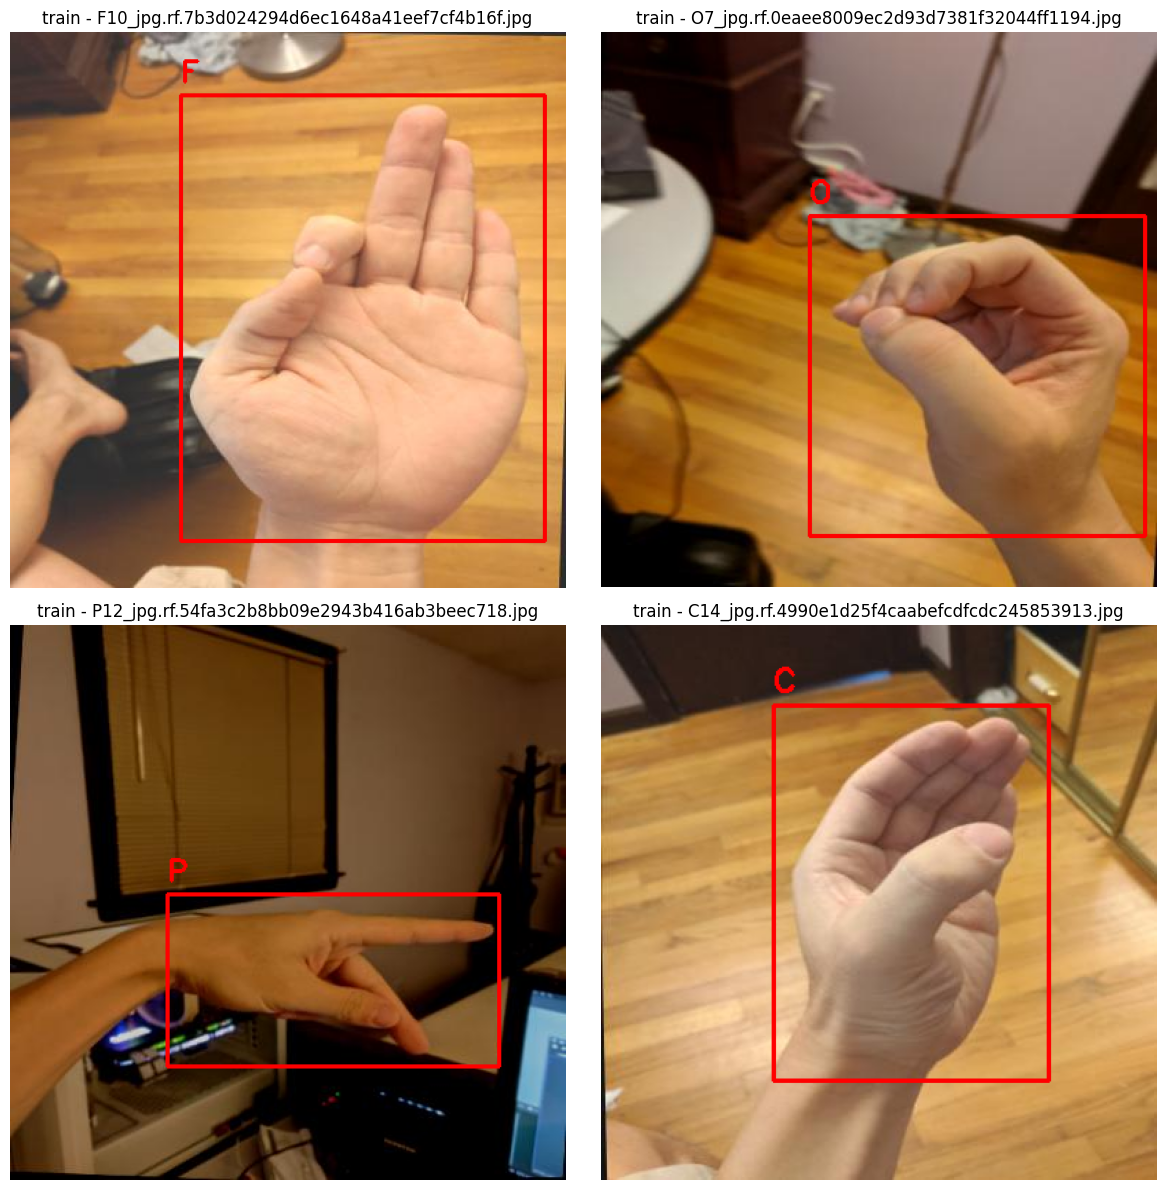


Sample images from val set:


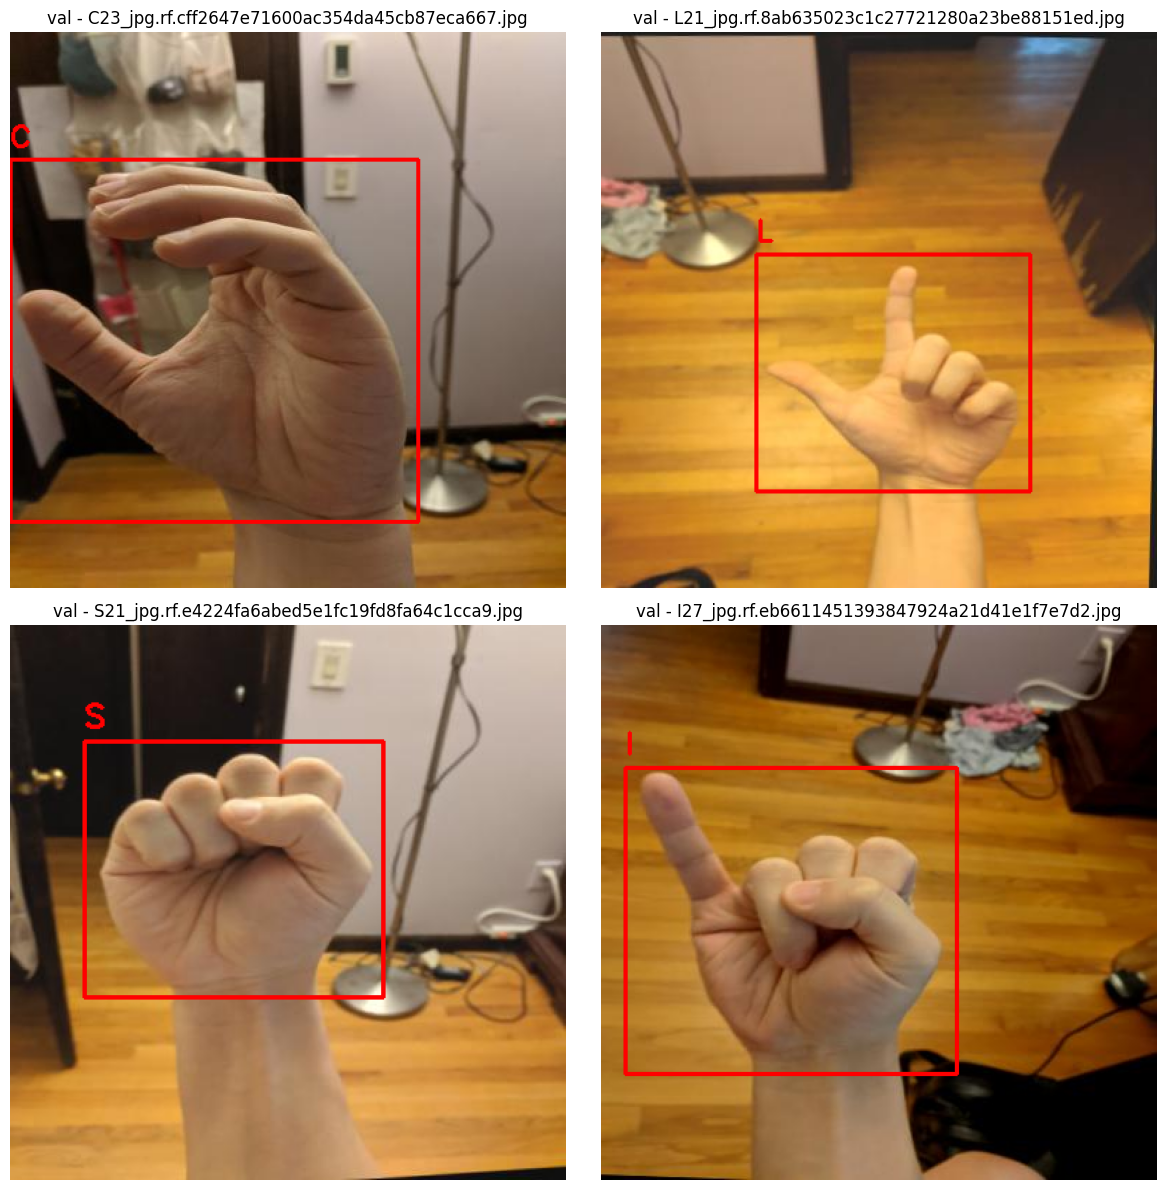


Sample images from test set:


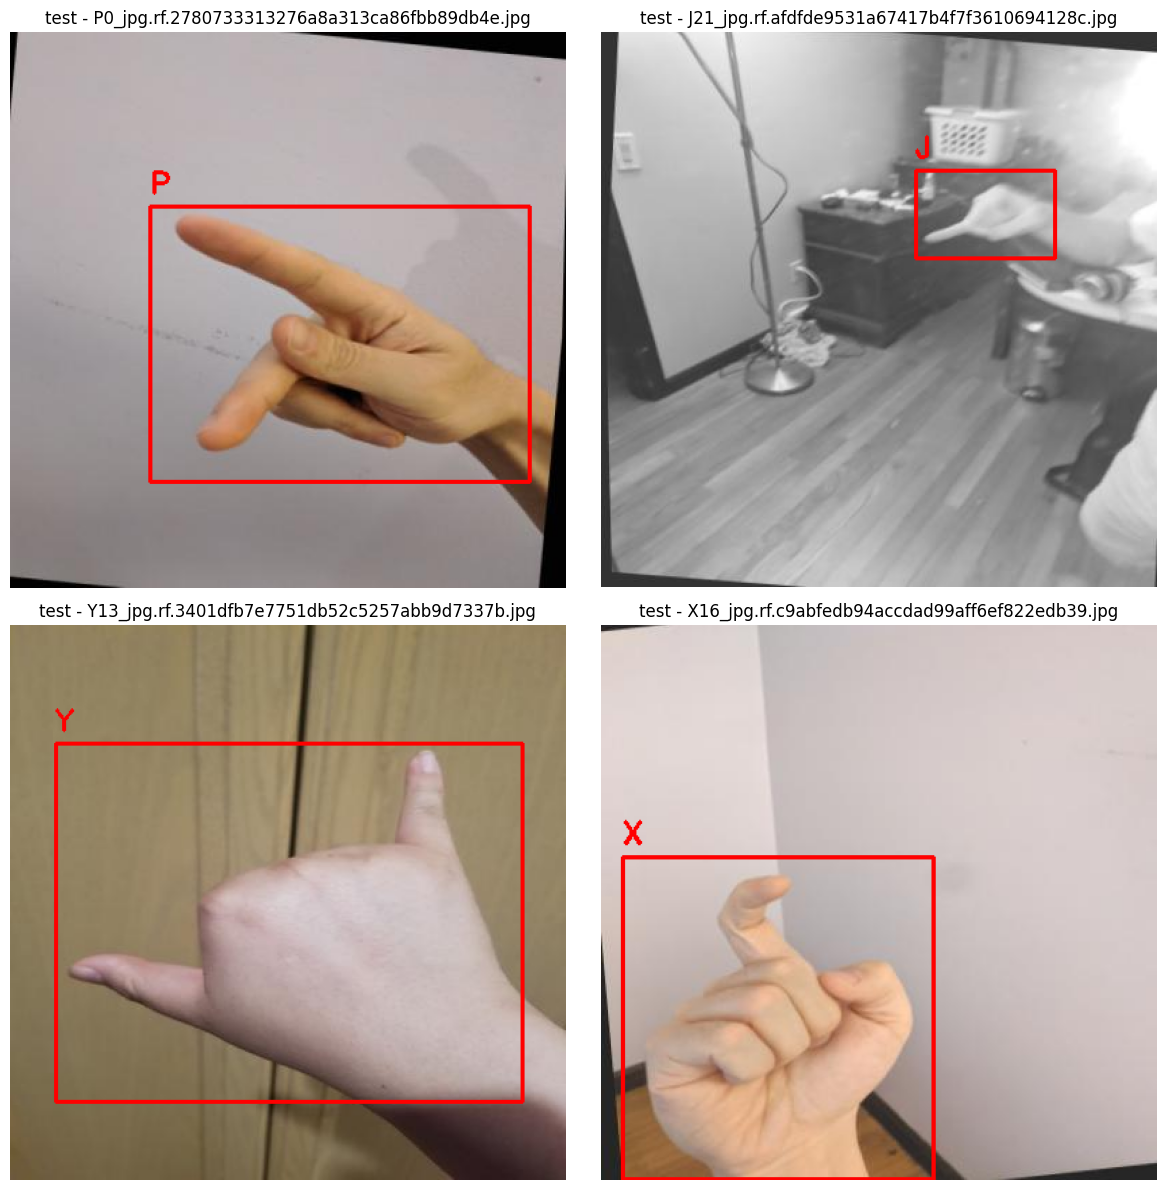

In [59]:
def visualize_samples(output_path, split='train', num_samples=4):
    """Visualize sample images with their annotations."""
    images_dir = os.path.join(output_path, split, 'images')
    labels_dir = os.path.join(output_path, split, 'labels')

    image_files = [f for f in os.listdir(images_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
    sample_files = random.sample(image_files, min(num_samples, len(image_files)))

    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    axes = axes.ravel()

    for idx, img_file in enumerate(sample_files):
        if idx >= 4:
            break

        # Load image
        img_path = os.path.join(images_dir, img_file)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        h, w = image.shape[:2]

        # Load annotations
        base_name = os.path.splitext(img_file)[0]
        label_path = os.path.join(labels_dir, base_name + '.txt')

        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                lines = f.readlines()

            for line in lines:
                parts = line.strip().split()
                if len(parts) == 5:
                    class_id, x_center, y_center, width, height = map(float, parts)

                    # Convert to pixel coordinates
                    x_center *= w
                    y_center *= h
                    width *= w
                    height *= h

                    # Draw bounding box
                    x1 = int(x_center - width/2)
                    y1 = int(y_center - height/2)
                    x2 = int(x_center + width/2)
                    y2 = int(y_center + height/2)

                    cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)

                    # Add class label
                    if int(class_id) < len(CLASS_NAMES):
                        label = CLASS_NAMES[int(class_id)]
                        cv2.putText(image, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)

        axes[idx].imshow(image)
        axes[idx].set_title(f'{split} - {img_file}')
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize samples from each split
for split in ['train', 'val', 'test']:
    print(f"\nSample images from {split} set:")
    visualize_samples(OUTPUT_PATH, split)

In [60]:
def train_yolo_model(yaml_config_path, model_size, epochs, image_size, batch_size):
    """Train YOLOv8 model."""
    print(f"Starting training with {model_size}")
    print(f"Configuration: epochs={epochs}, image_size={image_size}, batch_size={batch_size}")

    # Load model
    model = YOLO(model_size)

    # Train the model
    results = model.train(
        data=yaml_config_path,
        epochs=epochs,
        imgsz=image_size,
        batch=batch_size,
        save=True,
        project='ASL-fingerspelling',
        name='asl-model',
        exist_ok=True, # overwrite
        patience=20,
        save_period=10
    )

    return model, results

# Start training
print("Initializing model training...")
model, training_results = train_yolo_model(
    yaml_config_path, MODEL_SIZE, EPOCHS, IMAGE_SIZE, BATCH_SIZE
)

print("Training completed!")

Initializing model training...
Starting training with yolov8n.pt
Configuration: epochs=100, image_size=640, batch_size=16


Ultralytics 8.3.159 🚀 Python-3.13.3 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 4060, 7816MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo_dataset_split/dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=asl-model, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=20, perspective=0.0, plots=True, pose=

train: Scanning /home/kjasman/Documents/Summer2025/SENG474/ASL-Fingerspelling/YOLO/yolo_dataset_split/train/labels... 1209 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1209/1209 [00:00<00:00, 6140.03it/s]


train: New cache created: /home/kjasman/Documents/Summer2025/SENG474/ASL-Fingerspelling/YOLO/yolo_dataset_split/train/labels.cache
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 592.6±285.2 MB/s, size: 10.9 KB)


val: Scanning /home/kjasman/Documents/Summer2025/SENG474/ASL-Fingerspelling/YOLO/yolo_dataset_split/val/labels... 259 images, 0 backgrounds, 0 corrupt: 100%|██████████| 259/259 [00:00<00:00, 3796.04it/s]

val: New cache created: /home/kjasman/Documents/Summer2025/SENG474/ASL-Fingerspelling/YOLO/yolo_dataset_split/val/labels.cache


Plotting labels to ASL-fingerspelling/asl-model/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000333, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to ASL-fingerspelling/asl-model
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.14G      1.056      4.346      1.495         14        640: 100%|██████████| 76/76 [00:07<00:00, 10.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.25it/s]

                   all        259        259     0.0335      0.692     0.0892     0.0703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.31G     0.8854      3.685      1.344         22        640: 100%|██████████| 76/76 [00:06<00:00, 10.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.02it/s]


                   all        259        259      0.282      0.488       0.28      0.224

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.31G      0.921      3.164      1.366         22        640: 100%|██████████| 76/76 [00:06<00:00, 11.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.07it/s]


                   all        259        259      0.408      0.511      0.462      0.369

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.31G      0.896      2.864      1.346         13        640: 100%|██████████| 76/76 [00:06<00:00, 11.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.01it/s]


                   all        259        259      0.442      0.633      0.568      0.467

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.31G     0.8768        2.6      1.313         19        640: 100%|██████████| 76/76 [00:06<00:00, 11.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.03it/s]


                   all        259        259        0.6      0.656       0.73      0.587

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.31G     0.8714       2.41      1.302         19        640: 100%|██████████| 76/76 [00:06<00:00, 11.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.06it/s]


                   all        259        259      0.725      0.697      0.777      0.656

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.31G     0.8437      2.257      1.277         13        640: 100%|██████████| 76/76 [00:06<00:00, 11.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.04it/s]


                   all        259        259      0.775      0.708      0.838      0.706

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.31G     0.8345      2.037      1.265         22        640: 100%|██████████| 76/76 [00:06<00:00, 11.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.11it/s]


                   all        259        259      0.672      0.796      0.845      0.717

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.31G      0.789       1.91      1.222         18        640: 100%|██████████| 76/76 [00:06<00:00, 11.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.10it/s]


                   all        259        259      0.739      0.815      0.885      0.755

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.33G      0.796      1.863      1.229         17        640: 100%|██████████| 76/76 [00:06<00:00, 11.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.07it/s]


                   all        259        259      0.792      0.835      0.913      0.765

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.35G      0.762      1.708      1.199         22        640: 100%|██████████| 76/76 [00:06<00:00, 11.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.10it/s]


                   all        259        259      0.794      0.863      0.906      0.771

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.36G     0.7568      1.641      1.205         21        640: 100%|██████████| 76/76 [00:06<00:00, 11.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.17it/s]

                   all        259        259      0.867      0.849      0.933      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.38G      0.761      1.611        1.2         20        640: 100%|██████████| 76/76 [00:06<00:00, 11.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.17it/s]


                   all        259        259      0.868      0.876      0.944      0.811

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100       2.4G     0.7682      1.548      1.199         18        640: 100%|██████████| 76/76 [00:06<00:00, 11.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.12it/s]


                   all        259        259      0.912      0.885      0.961      0.821

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.42G     0.7401      1.426      1.174         23        640: 100%|██████████| 76/76 [00:06<00:00, 11.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.15it/s]


                   all        259        259      0.922        0.9      0.972      0.844

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.43G     0.7202       1.41      1.166         17        640: 100%|██████████| 76/76 [00:06<00:00, 11.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.16it/s]


                   all        259        259       0.92      0.908      0.969      0.834

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.45G       0.74      1.409      1.183         20        640: 100%|██████████| 76/76 [00:06<00:00, 11.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.16it/s]


                   all        259        259       0.91      0.929      0.982      0.847

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.47G     0.7281      1.337       1.17         22        640: 100%|██████████| 76/76 [00:06<00:00, 11.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.17it/s]


                   all        259        259      0.955      0.925      0.974      0.847

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.48G     0.7396      1.335      1.177         23        640: 100%|██████████| 76/76 [00:06<00:00, 11.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.15it/s]


                   all        259        259      0.905      0.949      0.975      0.844

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100       2.5G     0.7324      1.312      1.176         27        640: 100%|██████████| 76/76 [00:06<00:00, 11.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.21it/s]

                   all        259        259      0.925       0.93      0.973      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.52G     0.6979      1.244      1.148         14        640: 100%|██████████| 76/76 [00:06<00:00, 11.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.20it/s]


                   all        259        259      0.928      0.951      0.986      0.848

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.54G     0.7238      1.269      1.167         19        640: 100%|██████████| 76/76 [00:06<00:00, 11.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.23it/s]

                   all        259        259      0.908       0.96      0.986      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.55G     0.7103      1.194      1.158         20        640: 100%|██████████| 76/76 [00:06<00:00, 11.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.17it/s]

                   all        259        259      0.934      0.927      0.984       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.57G       0.72      1.218      1.161         25        640: 100%|██████████| 76/76 [00:06<00:00, 11.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.18it/s]

                   all        259        259      0.921      0.953      0.985      0.856



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.59G     0.6915      1.134      1.134         15        640: 100%|██████████| 76/76 [00:06<00:00, 11.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.23it/s]

                   all        259        259       0.95      0.962      0.989      0.864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100       2.6G     0.6843      1.117      1.142         21        640: 100%|██████████| 76/76 [00:06<00:00, 11.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.17it/s]


                   all        259        259      0.932      0.951      0.988      0.856

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.62G     0.6883      1.113      1.141         21        640: 100%|██████████| 76/76 [00:06<00:00, 11.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.25it/s]

                   all        259        259       0.95      0.959      0.989      0.871



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.64G     0.6758      1.072      1.124         18        640: 100%|██████████| 76/76 [00:06<00:00, 11.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.28it/s]

                   all        259        259       0.93      0.969      0.988      0.865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.65G     0.6917      1.083      1.143         20        640: 100%|██████████| 76/76 [00:06<00:00, 11.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.23it/s]

                   all        259        259      0.951      0.956      0.987      0.865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.67G     0.6521      1.005       1.11         25        640: 100%|██████████| 76/76 [00:06<00:00, 11.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.25it/s]

                   all        259        259      0.973      0.959       0.99      0.864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.69G     0.6845      1.061      1.131         16        640: 100%|██████████| 76/76 [00:06<00:00, 11.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.26it/s]

                   all        259        259      0.955      0.967      0.991      0.869



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.71G     0.6608     0.9965      1.117         20        640: 100%|██████████| 76/76 [00:06<00:00, 11.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.23it/s]

                   all        259        259      0.954       0.97      0.991      0.868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.72G     0.6611      1.016      1.121         23        640: 100%|██████████| 76/76 [00:06<00:00, 11.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.21it/s]


                   all        259        259      0.965      0.958       0.99       0.87

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.74G      0.659     0.9726      1.118         23        640: 100%|██████████| 76/76 [00:06<00:00, 11.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.27it/s]


                   all        259        259      0.963      0.961      0.992      0.862

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.76G     0.6397     0.9663       1.11         23        640: 100%|██████████| 76/76 [00:06<00:00, 11.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.30it/s]

                   all        259        259      0.926      0.974      0.989      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.78G      0.672     0.9642      1.122         23        640: 100%|██████████| 76/76 [00:06<00:00, 11.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.23it/s]

                   all        259        259      0.959      0.957      0.984      0.871



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100       2.8G     0.6434     0.9213      1.114         15        640: 100%|██████████| 76/76 [00:06<00:00, 11.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.28it/s]

                   all        259        259      0.973      0.976       0.99      0.876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.81G     0.6418     0.9234      1.101         26        640: 100%|██████████| 76/76 [00:06<00:00, 11.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.23it/s]


                   all        259        259      0.961      0.981       0.99      0.877

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.83G     0.6542     0.9234      1.125         24        640: 100%|██████████| 76/76 [00:06<00:00, 11.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.27it/s]

                   all        259        259      0.939      0.961       0.98      0.857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.84G     0.6433     0.9051       1.11         20        640: 100%|██████████| 76/76 [00:06<00:00, 11.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.28it/s]

                   all        259        259      0.957      0.966      0.988      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.86G      0.639     0.8979      1.105         18        640: 100%|██████████| 76/76 [00:06<00:00, 11.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.27it/s]

                   all        259        259      0.964      0.964      0.984      0.866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.88G     0.6325     0.8801      1.101         13        640: 100%|██████████| 76/76 [00:06<00:00, 11.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.24it/s]

                   all        259        259      0.969      0.977      0.987      0.874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.89G      0.627      0.868      1.099         22        640: 100%|██████████| 76/76 [00:06<00:00, 11.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.27it/s]

                   all        259        259      0.976      0.971      0.992      0.872



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.91G     0.6219     0.8486        1.1         13        640: 100%|██████████| 76/76 [00:06<00:00, 11.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.24it/s]

                   all        259        259      0.976      0.973      0.992      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.93G     0.6281     0.8581      1.096         22        640: 100%|██████████| 76/76 [00:06<00:00, 11.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.32it/s]

                   all        259        259      0.958      0.959      0.987      0.876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.95G      0.627     0.8566      1.097         20        640: 100%|██████████| 76/76 [00:06<00:00, 11.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.29it/s]

                   all        259        259      0.972      0.958      0.993      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.96G     0.6238     0.8261        1.1         13        640: 100%|██████████| 76/76 [00:06<00:00, 11.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.28it/s]

                   all        259        259      0.968      0.972      0.993      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.98G     0.6101      0.808      1.088         24        640: 100%|██████████| 76/76 [00:06<00:00, 11.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.28it/s]

                   all        259        259      0.974      0.971      0.993      0.871



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100         3G     0.5955     0.7943      1.079         21        640: 100%|██████████| 76/76 [00:06<00:00, 11.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.33it/s]

                   all        259        259      0.974      0.973      0.992      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      3.01G     0.5952      0.793      1.078         19        640: 100%|██████████| 76/76 [00:06<00:00, 11.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.29it/s]

                   all        259        259      0.979      0.965      0.993      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      3.03G     0.6095     0.7974      1.081         20        640: 100%|██████████| 76/76 [00:06<00:00, 11.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.33it/s]

                   all        259        259      0.972      0.975       0.99      0.877



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      3.05G     0.5921     0.7695      1.076         24        640: 100%|██████████| 76/76 [00:06<00:00, 11.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.25it/s]

                   all        259        259      0.952      0.973      0.991       0.88



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      3.06G     0.6065     0.7648      1.082         17        640: 100%|██████████| 76/76 [00:06<00:00, 11.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.33it/s]

                   all        259        259      0.971      0.956      0.989      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      3.08G     0.5888     0.7713      1.079         23        640: 100%|██████████| 76/76 [00:06<00:00, 11.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.33it/s]

                   all        259        259      0.956       0.98      0.992      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100       3.1G     0.5838     0.7416       1.07         19        640: 100%|██████████| 76/76 [00:06<00:00, 11.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.33it/s]

                   all        259        259      0.984      0.969      0.992      0.874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      3.12G     0.5873     0.7587      1.077         23        640: 100%|██████████| 76/76 [00:06<00:00, 11.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.32it/s]

                   all        259        259      0.977      0.978      0.993       0.88



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      3.13G     0.5974     0.7413      1.081         24        640: 100%|██████████| 76/76 [00:06<00:00, 11.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.28it/s]

                   all        259        259      0.955      0.983      0.992      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      3.15G     0.5808     0.7374      1.066         12        640: 100%|██████████| 76/76 [00:06<00:00, 11.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.23it/s]


                   all        259        259      0.975      0.971      0.993      0.883

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      3.17G     0.5707     0.6904      1.057         19        640: 100%|██████████| 76/76 [00:06<00:00, 11.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.31it/s]

                   all        259        259      0.986      0.977      0.995      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      3.19G     0.5843     0.7156      1.074         18        640: 100%|██████████| 76/76 [00:06<00:00, 11.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.34it/s]

                   all        259        259      0.981      0.981      0.994      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100       3.2G     0.5758     0.6919      1.066         19        640: 100%|██████████| 76/76 [00:06<00:00, 11.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.31it/s]

                   all        259        259      0.982      0.966      0.992      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      3.22G     0.5702     0.6996      1.067         19        640: 100%|██████████| 76/76 [00:06<00:00, 11.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.31it/s]

                   all        259        259      0.981      0.974      0.994      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      3.24G     0.5663     0.6845      1.064         17        640: 100%|██████████| 76/76 [00:06<00:00, 11.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.32it/s]

                   all        259        259      0.986      0.973      0.994      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      3.25G     0.5495      0.664      1.048         21        640: 100%|██████████| 76/76 [00:06<00:00, 11.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.32it/s]

                   all        259        259      0.984      0.965      0.992      0.897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      3.27G     0.5479      0.664      1.046         18        640: 100%|██████████| 76/76 [00:06<00:00, 11.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.32it/s]

                   all        259        259       0.98      0.976      0.992      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      3.29G     0.5552     0.6631      1.054         25        640: 100%|██████████| 76/76 [00:06<00:00, 11.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.35it/s]

                   all        259        259      0.979      0.982      0.994      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100       3.3G      0.548     0.6616      1.057         20        640: 100%|██████████| 76/76 [00:06<00:00, 11.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.29it/s]

                   all        259        259      0.979      0.972      0.992      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      3.32G     0.5543     0.6614       1.05         27        640: 100%|██████████| 76/76 [00:06<00:00, 11.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.35it/s]

                   all        259        259      0.972       0.97      0.994      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      3.34G     0.5608     0.6432      1.059         21        640: 100%|██████████| 76/76 [00:06<00:00, 11.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.32it/s]

                   all        259        259      0.979       0.97      0.992      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      3.36G     0.5615     0.6668      1.057         23        640: 100%|██████████| 76/76 [00:06<00:00, 11.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.31it/s]

                   all        259        259      0.981      0.974      0.994       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      3.37G      0.545      0.636      1.043         20        640: 100%|██████████| 76/76 [00:06<00:00, 11.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.33it/s]

                   all        259        259      0.988       0.97      0.995      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      3.39G     0.5537     0.6429      1.048         30        640: 100%|██████████| 76/76 [00:06<00:00, 11.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.34it/s]

                   all        259        259       0.98      0.979      0.994      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      3.41G      0.542     0.6329      1.048         18        640: 100%|██████████| 76/76 [00:06<00:00, 11.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.25it/s]


                   all        259        259      0.977      0.972      0.994      0.885

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      3.43G     0.5463     0.6313      1.045         13        640: 100%|██████████| 76/76 [00:06<00:00, 11.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.33it/s]

                   all        259        259      0.967      0.975      0.994      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      3.44G     0.5343      0.621      1.047         21        640: 100%|██████████| 76/76 [00:06<00:00, 11.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.34it/s]

                   all        259        259      0.971      0.978      0.994      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      3.46G     0.5355      0.611      1.044         12        640: 100%|██████████| 76/76 [00:06<00:00, 11.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.33it/s]

                   all        259        259      0.987      0.977      0.993      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      3.48G     0.5298     0.5902      1.036         13        640: 100%|██████████| 76/76 [00:06<00:00, 11.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.33it/s]

                   all        259        259      0.979      0.976      0.994      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100       3.5G     0.5234     0.5956       1.03         15        640: 100%|██████████| 76/76 [00:06<00:00, 11.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.34it/s]

                   all        259        259      0.976      0.976      0.991      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      3.51G     0.5174     0.5884      1.038         19        640: 100%|██████████| 76/76 [00:06<00:00, 11.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.30it/s]

                   all        259        259      0.976      0.976       0.99      0.879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      3.53G     0.5245     0.5992       1.04         20        640: 100%|██████████| 76/76 [00:06<00:00, 11.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.35it/s]

                   all        259        259      0.977       0.97      0.991       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      3.54G     0.5231      0.593      1.038         23        640: 100%|██████████| 76/76 [00:06<00:00, 11.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.33it/s]

                   all        259        259      0.982      0.967      0.993      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      3.57G     0.5203     0.5897      1.042         18        640: 100%|██████████| 76/76 [00:06<00:00, 11.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.34it/s]

                   all        259        259      0.982       0.97      0.993      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      3.58G     0.5076     0.5702      1.027         25        640: 100%|██████████| 76/76 [00:06<00:00, 11.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.36it/s]

                   all        259        259      0.981      0.976      0.995      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100       3.6G     0.5182     0.5608      1.032         18        640: 100%|██████████| 76/76 [00:06<00:00, 11.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.27it/s]

                   all        259        259      0.986      0.971      0.994      0.894
EarlyStopping: Training stopped early as no improvement observed in last 20 epochs. Best results observed at epoch 64, best model saved as best.pt.
To update EarlyStopping(patience=20) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



84 epochs completed in 0.180 hours.
Optimizer stripped from ASL-fingerspelling/asl-model/weights/last.pt, 6.3MB
Optimizer stripped from ASL-fingerspelling/asl-model/weights/best.pt, 6.3MB

Validating ASL-fingerspelling/asl-model/weights/best.pt...
Ultralytics 8.3.159 🚀 Python-3.13.3 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 4060, 7816MiB)
Model summary (fused): 72 layers, 3,010,718 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 10.01it/s]


                   all        259        259      0.984      0.965      0.992      0.896
                     A          9          9       0.99          1      0.995      0.894
                     B         10         10      0.987          1      0.995      0.897
                     C          9          9      0.988          1      0.995       0.91
                     D         11         11          1      0.929      0.995      0.871
                     E         14         14      0.992          1      0.995       0.92
                     F         14         14      0.981          1      0.995      0.907
                     G         12         12          1      0.904      0.989      0.872
                     H          9          9      0.915      0.889      0.984      0.803
                     I         14         14      0.992          1      0.995      0.913
                     J         19         19      0.994          1      0.995      0.893
                     

Running validation...
Ultralytics 8.3.159 🚀 Python-3.13.3 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 4060, 7816MiB)
Model summary (fused): 72 layers, 3,010,718 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1288.6±395.7 MB/s, size: 13.1 KB)


val: Scanning /home/kjasman/Documents/Summer2025/SENG474/ASL-Fingerspelling/YOLO/yolo_dataset_split/val/labels.cache... 259 images, 0 backgrounds, 0 corrupt: 100%|██████████| 259/259 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:01<00:00, 13.96it/s]


                   all        259        259      0.984      0.965      0.992      0.896
                     A          9          9       0.99          1      0.995      0.894
                     B         10         10      0.987          1      0.995      0.901
                     C          9          9      0.988          1      0.995       0.91
                     D         11         11          1      0.929      0.995      0.871
                     E         14         14      0.991          1      0.995      0.917
                     F         14         14      0.981          1      0.995      0.907
                     G         12         12          1      0.904      0.989      0.867
                     H          9          9      0.914      0.889      0.984      0.803
                     I         14         14      0.992          1      0.995      0.913
                     J         19         19      0.994          1      0.995      0.893
                     

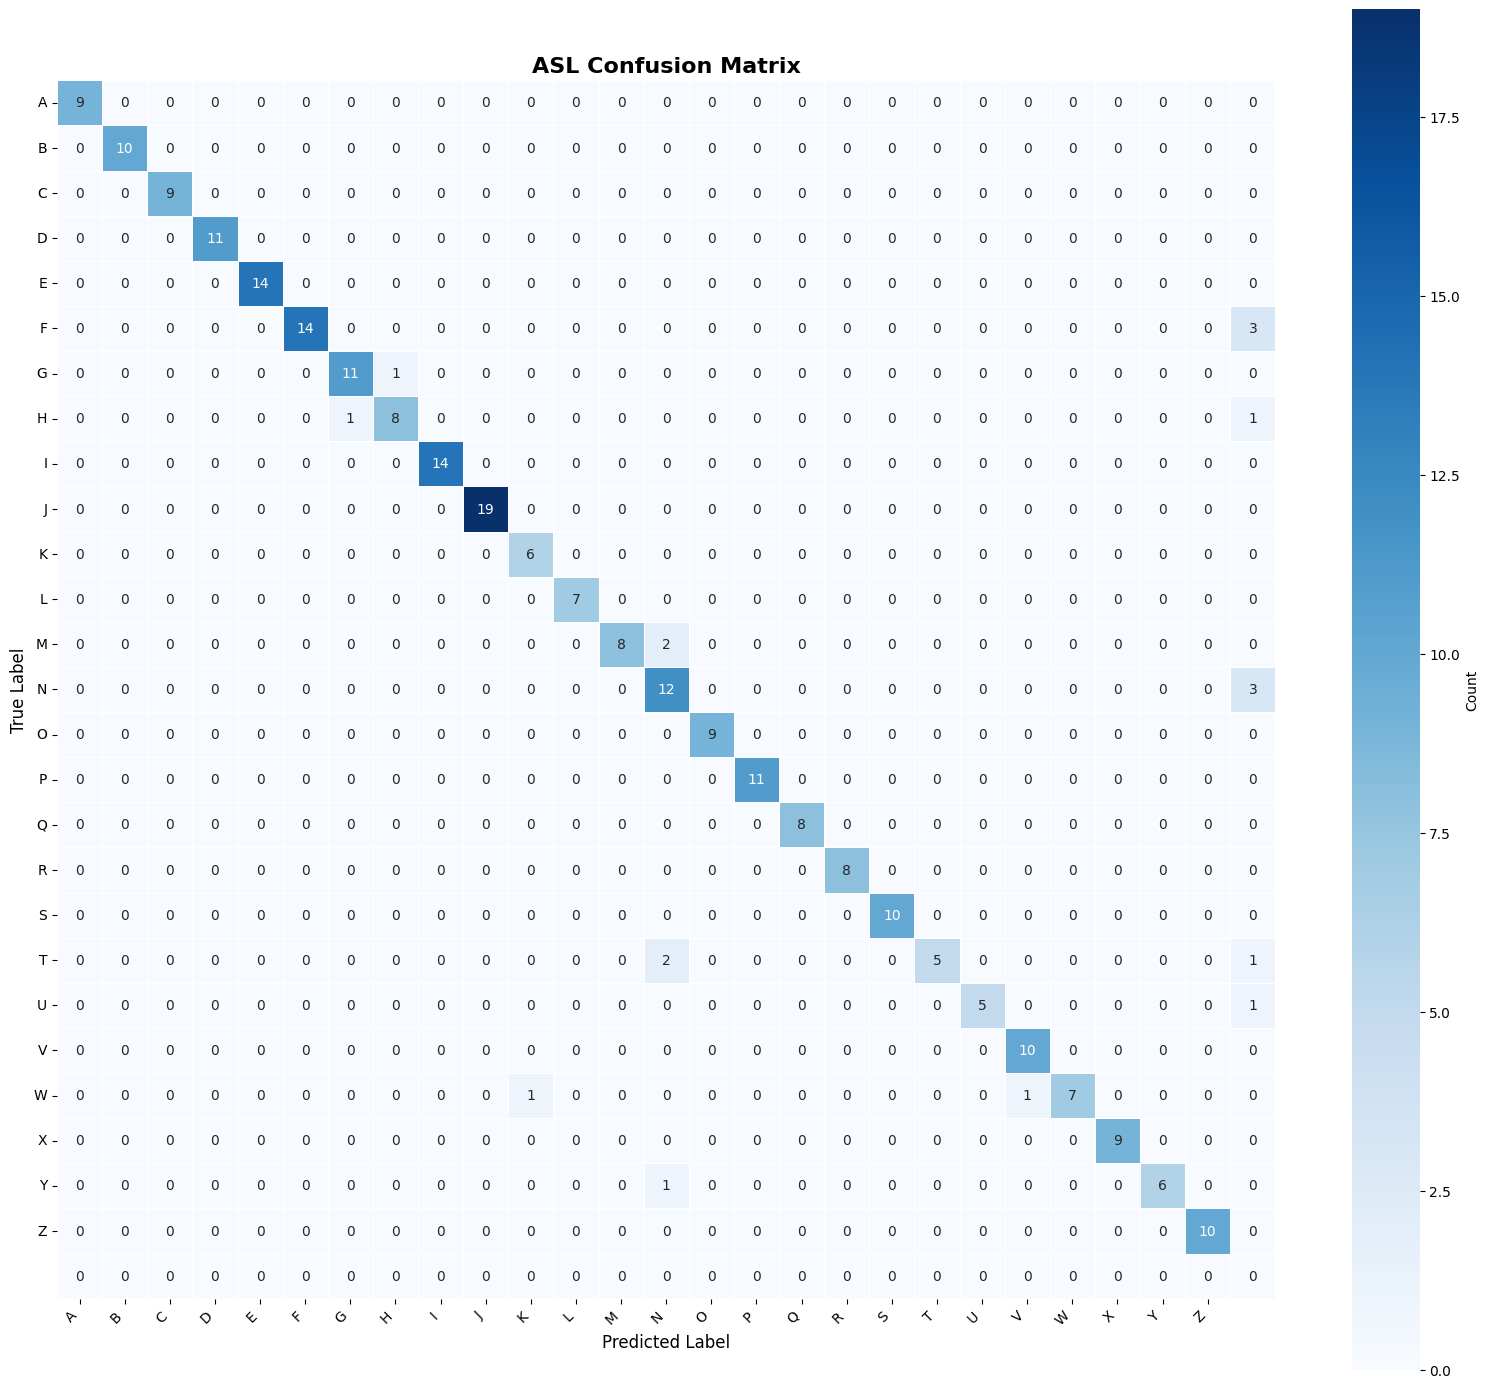

Overall Accuracy from Confusion Matrix: 0.9328
Running inference on test set...

image 1/260 /home/kjasman/Documents/Summer2025/SENG474/ASL-Fingerspelling/YOLO/yolo_dataset_split/test/images/A11_jpg.rf.ff2610c21c7f6d0a793cb58efc3bd96e.jpg: 640x640 1 A, 2.1ms
image 2/260 /home/kjasman/Documents/Summer2025/SENG474/ASL-Fingerspelling/YOLO/yolo_dataset_split/test/images/A15_jpg.rf.3654aa7d6bfc342c9ad99f500fd2aaf9.jpg: 640x640 1 A, 2.1ms
image 3/260 /home/kjasman/Documents/Summer2025/SENG474/ASL-Fingerspelling/YOLO/yolo_dataset_split/test/images/A16_jpg.rf.4792e25fdaf24e4180ae1a9c1513a39a.jpg: 640x640 1 A, 2.1ms
image 4/260 /home/kjasman/Documents/Summer2025/SENG474/ASL-Fingerspelling/YOLO/yolo_dataset_split/test/images/A1_jpg.rf.62756f145ef317dbd20ab731cbca01fd.jpg: 640x640 1 A, 2.1ms
image 5/260 /home/kjasman/Documents/Summer2025/SENG474/ASL-Fingerspelling/YOLO/yolo_dataset_split/test/images/A23_jpg.rf.199528cc21bad70f9424a2cfb92d3207.jpg: 640x640 1 A, 2.1ms
image 6/260 /home/kjasman/Docu

In [61]:
def plot_custom_confusion_matrix(val_results, model):
    """Plot custom confusion matrix from validation results."""
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    
    # Get confusion matrix and class names
    conf_matrix = np.array(val_results.confusion_matrix.matrix)
    class_names = list(model.names.values())
    
    # Determine if normalized or count data
    is_normalized = conf_matrix.max() <= 1.0
    
    # Create the plot
    plt.figure(figsize=(16, 14))
    
    if is_normalized:
        sns.heatmap(conf_matrix, annot=True, fmt='.2f', cmap='Blues',
                    square=True, cbar_kws={'label': 'Normalized Frequency'},
                    xticklabels=class_names, yticklabels=class_names,
                    linewidths=0.5)
        title = 'ASL Confusion Matrix (Normalized)'
    else:
        sns.heatmap(conf_matrix, annot=True, fmt='.0f', cmap='Blues',
                    square=True, cbar_kws={'label': 'Count'},
                    xticklabels=class_names, yticklabels=class_names,
                    linewidths=0.5)
        title = 'ASL Confusion Matrix'
    
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Print accuracy statistics
    if is_normalized:
        accuracy = np.trace(conf_matrix) / len(conf_matrix)
    else:
        total_samples = np.sum(conf_matrix)
        correct_predictions = np.trace(conf_matrix)
        accuracy = correct_predictions / total_samples
        print(f"Overall Accuracy from Confusion Matrix: {accuracy:.4f}")

def validate_model(model, yaml_config_path):
    """Validate the trained model."""
    print("Running validation...")

    # Validate on validation set
    val_results = model.val(
        data=yaml_config_path,
        save=False,          # Don't save prediction images
        save_json=False,     # Don't save JSON results
        save_txt=False,      # Don't save txt results
        plots=True          # Don't save automatic plots
    )

    print(f"mAP50: {val_results.box.map50:.4f}")
    print(f"mAP50-95: {val_results.box.map:.4f}")
    
    # Plot custom confusion matrix
    print("\nGenerating custom confusion matrix...")
    plot_custom_confusion_matrix(val_results, model)

    return val_results

def test_model(model, test_images_path):
    """Test the model on test set."""
    print("Running inference on test set...")

    test_results = model.predict(
        source=test_images_path,
        save=True,
        project='yolo_testing',
        name='test_results',
        exist_ok=True,     
        conf=0.25,
        iou=0.45
    )

    return test_results

# Validate the model
validation_results = validate_model(model, yaml_config_path)

# Test on test set
test_images_path = os.path.join(OUTPUT_PATH, 'test', 'images')
test_results = test_model(model, test_images_path)

In [62]:
def plot_training_results():
    """Plot training metrics from the results with column names."""
    import pandas as pd
    import matplotlib.pyplot as plt
    import os
    
    results_dir = 'yolo_training/custom_model'

    if os.path.exists(os.path.join(results_dir, 'results.csv')):
        # Load results
        df = pd.read_csv(os.path.join(results_dir, 'results.csv'))
        df.columns = df.columns.str.strip()  # Remove any whitespace
        
        # Create subplots
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # 1. Box Loss
        axes[0, 0].plot(df['epoch'], df['train/box_loss'], label='Train Box Loss', color='blue')
        axes[0, 0].plot(df['epoch'], df['val/box_loss'], label='Val Box Loss', color='orange')
        axes[0, 0].set_title('Box Loss')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True)

        # 2. Classification Loss
        axes[0, 1].plot(df['epoch'], df['train/cls_loss'], label='Train Cls Loss', color='blue')
        axes[0, 1].plot(df['epoch'], df['val/cls_loss'], label='Val Cls Loss', color='orange')
        axes[0, 1].set_title('Classification Loss')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Loss')
        axes[0, 1].legend()
        axes[0, 1].grid(True)

        # 3. mAP Metrics
        axes[1, 0].plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP@0.5', color='green')
        axes[1, 0].plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP@0.5:0.95', color='red')
        axes[1, 0].set_title('mAP Metrics')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('mAP')
        axes[1, 0].legend()
        axes[1, 0].grid(True)

        # 4. Precision and Recall
        axes[1, 1].plot(df['epoch'], df['metrics/precision(B)'], label='Precision', color='purple')
        axes[1, 1].plot(df['epoch'], df['metrics/recall(B)'], label='Recall', color='brown')
        axes[1, 1].set_title('Precision & Recall')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Score')
        axes[1, 1].legend()
        axes[1, 1].grid(True)

        plt.tight_layout()
        plt.show()
        
        # Print final metrics
        final_epoch = df.iloc[-1]
        print("\n" + "="*50)
        print("FINAL TRAINING METRICS (Epoch 100)")
        print("="*50)
        print(f"📊 Training Losses:")
        print(f"   Box Loss: {final_epoch['train/box_loss']:.4f}")
        print(f"   Cls Loss: {final_epoch['train/cls_loss']:.4f}")
        print(f"   DFL Loss: {final_epoch['train/dfl_loss']:.4f}")
        print(f"\n📊 Validation Losses:")
        print(f"   Box Loss: {final_epoch['val/box_loss']:.4f}")
        print(f"   Cls Loss: {final_epoch['val/cls_loss']:.4f}")
        print(f"   DFL Loss: {final_epoch['val/dfl_loss']:.4f}")
        print(f"\n🎯 Performance Metrics:")
        print(f"   Precision: {final_epoch['metrics/precision(B)']:.4f}")
        print(f"   Recall: {final_epoch['metrics/recall(B)']:.4f}")
        print(f"   mAP@0.5: {final_epoch['metrics/mAP50(B)']:.4f}")
        print(f"   mAP@0.5:0.95: {final_epoch['metrics/mAP50-95(B)']:.4f}")
        
    else:
        print("Training results not found. Check the training output directory.")

def plot_additional_metrics():
    """Plot additional training metrics like DFL loss and learning rates."""
    import pandas as pd
    import matplotlib.pyplot as plt
    import os
    
    results_dir = 'yolo_training/custom_model'

    if os.path.exists(os.path.join(results_dir, 'results.csv')):
        df = pd.read_csv(os.path.join(results_dir, 'results.csv'))
        df.columns = df.columns.str.strip()
        
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))

        # 1. DFL Loss (Distribution Focal Loss)
        axes[0].plot(df['epoch'], df['train/dfl_loss'], label='Train DFL Loss', color='blue')
        axes[0].plot(df['epoch'], df['val/dfl_loss'], label='Val DFL Loss', color='orange')
        axes[0].set_title('Distribution Focal Loss (DFL)')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('DFL Loss')
        axes[0].legend()
        axes[0].grid(True)

        # 2. Learning Rate Schedule
        axes[1].plot(df['epoch'], df['lr/pg0'], label='Learning Rate', color='red')
        axes[1].set_title('Learning Rate Schedule')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Learning Rate')
        axes[1].legend()
        axes[1].grid(True)
        axes[1].set_yscale('log')  # Log scale for better visualization

        plt.tight_layout()
        plt.show()
    else:
        print("Training results not found.")

# Run the corrected plotting functions
plot_training_results()
plot_additional_metrics()



Training results not found. Check the training output directory.
Training results not found.


Testing prediction on: yolo_dataset_split/test/images/E19_jpg.rf.f9ccc5ec73209f6eecaca429420f30c3.jpg

image 1/1 /home/kjasman/Documents/Summer2025/SENG474/ASL-Fingerspelling/YOLO/yolo_dataset_split/test/images/E19_jpg.rf.f9ccc5ec73209f6eecaca429420f30c3.jpg: 640x640 1 E, 2.5ms
Speed: 13.1ms preprocess, 2.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


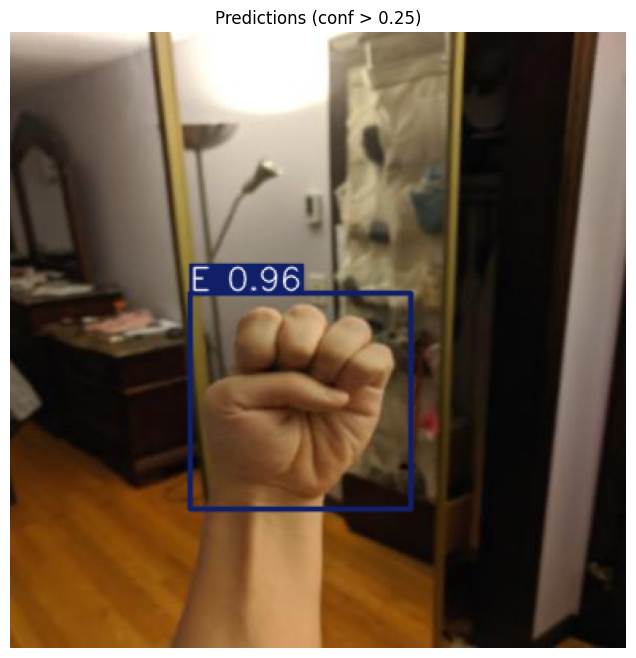

Detection 1: E (confidence: 0.961)


In [65]:
def predict_single_image(model, image_path, conf_threshold=0.25):
    """Make prediction on a single image."""
    results = model.predict(
        source=image_path,
        conf=conf_threshold,
        save=False,
        show=False
    )

    # Display results
    for r in results:
        # Plot results
        im_array = r.plot()
        plt.figure(figsize=(10, 8))
        plt.imshow(cv2.cvtColor(im_array, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(f'Predictions (conf > {conf_threshold})')
        plt.show()

        # Print detection info
        if len(r.boxes) > 0:
            for i, box in enumerate(r.boxes):
                class_id = int(box.cls[0])
                confidence = float(box.conf[0])
                class_name = CLASS_NAMES[class_id] if class_id < len(CLASS_NAMES) else f"Class_{class_id}"
                print(f"Detection {i+1}: {class_name} (confidence: {confidence:.3f})")
        else:
            print("No detections found")

# Test prediction on a sample image
test_images = os.listdir(os.path.join(OUTPUT_PATH, 'test', 'images'))
if test_images:
    sample_image = os.path.join(OUTPUT_PATH, 'test', 'images', test_images[0])
    print(f"Testing prediction on: {sample_image}")
    predict_single_image(model, sample_image)

In [64]:
print("="*60)
print("TRAINING SUMMARY")
print("="*60)
print(f"Original dataset: /data/YOLO-Bulk")
print(f"Dataset split completed: {OUTPUT_PATH}")
print(f"Class names loaded from: /data/YOLO-Bulk/data.yaml")
print(f"Model trained for {EPOCHS} epochs")
print(f"Best model saved in: yolo_training/custom_model/weights/")
print(f"Validation results available")
print(f"Test predictions saved in: yolo_testing/test_results/")

print("\nNext steps:")
print("1. Review training metrics and validation results")
print("2. Adjust hyperparameters if needed")
print("3. Test on new images using the trained model")
print("4. Deploy the model for inference")
print("5. Consider data augmentation if performance needs improvement")

# Final model path
final_model_path = "yolo_training/custom_model/weights/best.pt"
print(f"\nTo load the trained model later:")
print(f"model = YOLO('{final_model_path}')")

print(f"\nYour original dataset remains unchanged at: /data/YOLO-Bulk")
print(f"Split dataset is available at: {OUTPUT_PATH}")

TRAINING SUMMARY
Original dataset: /data/YOLO-Bulk
Dataset split completed: yolo_dataset_split
Class names loaded from: /data/YOLO-Bulk/data.yaml
Model trained for 100 epochs
Best model saved in: yolo_training/custom_model/weights/
Validation results available
Test predictions saved in: yolo_testing/test_results/

Next steps:
1. Review training metrics and validation results
2. Adjust hyperparameters if needed
3. Test on new images using the trained model
4. Deploy the model for inference
5. Consider data augmentation if performance needs improvement

To load the trained model later:
model = YOLO('yolo_training/custom_model/weights/best.pt')

Your original dataset remains unchanged at: /data/YOLO-Bulk
Split dataset is available at: yolo_dataset_split
